In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from rfpimp import importances
from rfpimp import plot_importances
from rfpimp import plot_corr_heatmap
%matplotlib inline
pd.set_option("display.max_columns", 2000)

In [2]:
df_full=pd.read_csv('data/Seasons_Stats.csv')
df_full.drop(columns='Unnamed: 0', inplace=True)

In [3]:
df=df_full[df_full['Year']>=2005]
df.drop(labels='blank2', axis=1, inplace=True)
df.drop(labels='blanl', axis=1, inplace=True)
df['Year']=df['Year'].astype(int)
df['Year']=pd.to_datetime(df['Year'], format='%Y')
df['Year']=df['Year'].dt.year

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [4]:
def remove_tot(combined):
    tot_player=combined[combined['Tm']=='TOT']['Player'].values
    for name in tot_player:
        temp=combined[combined['Player']==name]
        tot_index=temp[temp['Tm']=='TOT'].index.values
        for idx in tot_index:
            year=temp.loc[idx]['Year']
            year_index=temp[temp['Year']==year].index.values
            year_temp=temp[temp['Year']==year]
            max_year=((year_temp[year_temp['Tm']!='TOT'])['G'].max())
            team=(year_temp[year_temp['G']==max_year])['Tm'].values
            team=str(team)
            team=team[1:-1]
            combined.at[idx,'Tm']=team
            for element in year_index:
                if element==idx:
                    continue
                else:
                    combined.drop(axis=0, index=element, inplace=True)
    return(combined)

In [5]:
df=remove_tot(df)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
df=df.drop_duplicates(subset=['Year','Player'], keep=False)

In [9]:
df_coach=pd.read_csv('data/coach_data_cleaned.csv')

In [10]:
df_coach['season']=df_coach['season'].apply(lambda x: x[:2]+x[-2:]) #code for fixing ther dates

In [12]:
df_coach.head(20)

,Unnamed: 0,Team,coach_age,coach_name,season,playoff_games,playoff_wins,playoff_loses,playoff_W/L%,season_games,season_wins,season_loses,season_W/L%,season_position
0,6,POR,42.0,Rick Adelman,1989,3.0,0.0,3.0,0.000,35,14.0,21.0,0.400,5.0
1,7,POR,43.0,Rick Adelman,1990,21.0,12.0,9.0,0.571,82,59.0,23.0,0.720,2.0
2,8,POR,44.0,Rick Adelman,1991,16.0,9.0,7.0,0.563,82,63.0,19.0,0.768,1.0
3,9,POR,45.0,Rick Adelman,1992,21.0,13.0,8.0,0.619,82,57.0,25.0,0.695,1.0
4,10,POR,46.0,Rick Adelman,1993,4.0,1.0,3.0,0.250,82,51.0,31.0,0.622,3.0
5,11,POR,47.0,Rick Adelman,1994,4.0,1.0,3.0,0.250,82,47.0,35.0,0.573,4.0
6,12,GSW,49.0,Rick Adelman,1996,NaN,NaN,NaN,NaN,82,36.0,46.0,0.439,6.0
7,13,GSW,50.0,Rick Adelman,1997,NaN,NaN,NaN,NaN,82,30.0,52.0,0.366,7.0
8,14,SAC,52.0,Rick Adelman,1999,5.0,2.0,3.0,0.400,50,27.0,23.0,0.540,4.0
9,15,SAC,53.0,Rick Adelman,1900,5.0,2.0,3.0,0.400,82,44.0,38.0,0.537,5.0


In [15]:
df_coach.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [16]:
df_coach.head()

,Team,coach_age,coach_name,season,playoff_games,playoff_wins,playoff_loses,playoff_W/L%,season_games,season_wins,season_loses,season_W/L%,season_position
0,POR,42.0,Rick Adelman,1989,3.0,0.0,3.0,0.000,35,14.0,21.0,0.400,5.0
1,POR,43.0,Rick Adelman,1990,21.0,12.0,9.0,0.571,82,59.0,23.0,0.720,2.0
2,POR,44.0,Rick Adelman,1991,16.0,9.0,7.0,0.563,82,63.0,19.0,0.768,1.0
3,POR,45.0,Rick Adelman,1992,21.0,13.0,8.0,0.619,82,57.0,25.0,0.695,1.0
4,POR,46.0,Rick Adelman,1993,4.0,1.0,3.0,0.250,82,51.0,31.0,0.622,3.0


In [130]:
df_coach[['Team','coach_name','season_W/L%','season']];

In [26]:
df_coach=df_coach[df_coach['season']!='Career']

In [41]:
null=df_coach[df_coach[['Team','coach_name','season_W/L%','season']].isnull().any(axis=1)]

In [132]:
# df_coach[df_coach['season']=='Caer'];

In [45]:
df_coach=df_coach[df_coach['season']!='Caer']

In [133]:
df_coach.sample(10);

In [50]:
df_coach=df_coach[df_coach['season']>1999]

TypeError: '>' not supported between instances of 'str' and 'int'

In [53]:
df_coach.head()

,Team,coach_age,coach_name,season,playoff_games,playoff_wins,playoff_loses,playoff_W/L%,season_games,season_wins,season_loses,season_W/L%,season_position
0,POR,42.0,Rick Adelman,1989,3.0,0.0,3.0,0.000,35,14.0,21.0,0.400,5.0
1,POR,43.0,Rick Adelman,1990,21.0,12.0,9.0,0.571,82,59.0,23.0,0.720,2.0
2,POR,44.0,Rick Adelman,1991,16.0,9.0,7.0,0.563,82,63.0,19.0,0.768,1.0
3,POR,45.0,Rick Adelman,1992,21.0,13.0,8.0,0.619,82,57.0,25.0,0.695,1.0
4,POR,46.0,Rick Adelman,1993,4.0,1.0,3.0,0.250,82,51.0,31.0,0.622,3.0


In [54]:
df_coach['season']=pd.to_datetime(df_coach['season'], format='%Y')

In [56]:
df_coach['season']=df_coach['season'].dt.year

In [58]:
df_c=df_coach[df_coach['season']>1999]

In [60]:
df_c.shape

(646, 13)

In [65]:
df_c[['Team','season','season_W/L%','coach_name']];

In [66]:
df_c['prev_season']=df_c['season']-1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
df_c.head()

,Team,coach_age,coach_name,season,playoff_games,playoff_wins,playoff_loses,playoff_W/L%,season_games,season_wins,season_loses,season_W/L%,season_position,prev_season
10,SAC,54.0,Rick Adelman,2001,8.0,3.0,5.0,0.375,82,55.0,27.0,0.671,2.0,2000
11,SAC,55.0,Rick Adelman,2002,16.0,10.0,6.0,0.625,82,61.0,21.0,0.744,1.0,2001
12,SAC,56.0,Rick Adelman,2003,12.0,7.0,5.0,0.583,82,59.0,23.0,0.720,1.0,2002
13,SAC,57.0,Rick Adelman,2004,12.0,7.0,5.0,0.583,82,55.0,27.0,0.671,2.0,2003
14,SAC,58.0,Rick Adelman,2005,5.0,1.0,4.0,0.200,82,50.0,32.0,0.610,2.0,2004


In [68]:
#adding the prev year:

In [ ]:
test4=pd.merge(combined,combined2[['Player','Year','ppg','Age','MP']], how='left', right_on=['Player','Year'], left_on=['Player','past_year'])

In [73]:
test=pd.merge(df_c,df_c[['season','coach_name','season_W/L%']], how='left', right_on=['coach_name','season'], left_on=['coach_name','prev_season'])

In [79]:
test[test['season_W/L%_y'].isna()]

,Team,coach_age,coach_name,season_x,playoff_games,playoff_wins,playoff_loses,playoff_W/L%,season_games,season_wins,season_loses,season_W/L%_x,season_position,prev_season,season_y,season_W/L%_y
0,SAC,54.0,Rick Adelman,2001,8.0,3.0,5.0,0.375,82,55.0,27.0,0.671,2.0,2000,NaN,NaN
6,HOU,61.0,Rick Adelman,2008,6.0,2.0,4.0,0.333,82,55.0,27.0,0.671,3.0,2007,NaN,NaN
13,BRK,49.0,Kenny Atkinson,2017,NaN,NaN,NaN,NaN,82,20.0,62.0,0.244,5.0,2016,NaN,NaN
16,PHI,47.0,Randy Ayers,2004,NaN,NaN,NaN,NaN,52,21.0,31.0,0.404,5.0,2003,NaN,NaN
17,MEM,60.0,Tony Barone,2007,NaN,NaN,NaN,NaN,52,16.0,36.0,0.308,5.0,2006,NaN,NaN
18,NJN,NaN,Tom Barrise,2010,NaN,NaN,NaN,NaN,2,0.0,2.0,0.000,5.0,2009,NaN,NaN
19,CHI,NaN,Bill Berry,2002,NaN,NaN,NaN,NaN,2,0.0,2.0,0.000,8.0,2001,NaN,NaN
20,CHA,60.0,Bernie Bickerstaff,2005,NaN,NaN,NaN,NaN,82,18.0,64.0,0.220,4.0,2004,NaN,NaN
23,LAL,68.0,Bernie Bickerstaff,2013,NaN,NaN,NaN,NaN,5,4.0,1.0,0.800,3.0,2012,NaN,NaN
24,HOU,36.0,J.B. Bickerstaff,2016,5.0,1.0,4.0,0.200,71,37.0,34.0,0.521,4.0,2015,NaN,NaN


In [82]:
test.columns

Index(['Team', 'coach_age', 'coach_name', 'season_x', 'playoff_games',
       'playoff_wins', 'playoff_loses', 'playoff_W/L%', 'season_games',
       'season_wins', 'season_loses', 'season_W/L%_x', 'season_position',
       'prev_season', 'season_y', 'season_W/L%_y'],
      dtype='object')

In [83]:
test=test[['Team', 'coach_age', 'coach_name', 'season_x','season_games',
       'season_wins', 'season_loses', 'season_W/L%_x', 'season_position',
       'prev_season', 'season_y', 'season_W/L%_y']]

In [85]:
test.head()

,Team,coach_age,coach_name,season_x,season_games,season_wins,season_loses,season_W/L%_x,season_position,prev_season,season_y,season_W/L%_y
0,SAC,54.0,Rick Adelman,2001,82,55.0,27.0,0.671,2.0,2000,NaN,NaN
1,SAC,55.0,Rick Adelman,2002,82,61.0,21.0,0.744,1.0,2001,2001.0,0.671
2,SAC,56.0,Rick Adelman,2003,82,59.0,23.0,0.720,1.0,2002,2002.0,0.744
3,SAC,57.0,Rick Adelman,2004,82,55.0,27.0,0.671,2.0,2003,2003.0,0.720
4,SAC,58.0,Rick Adelman,2005,82,50.0,32.0,0.610,2.0,2004,2004.0,0.671


In [89]:
test=test[~test['season_W/L%_y'].isna()]

In [90]:
test[test['coach_name']=='Rick Adelman']

,Team,coach_age,coach_name,season_x,season_games,season_wins,season_loses,season_W/L%_x,season_position,prev_season,season_y,season_W/L%_y
1,SAC,55.0,Rick Adelman,2002,82,61.0,21.0,0.744,1.0,2001,2001.0,0.671
2,SAC,56.0,Rick Adelman,2003,82,59.0,23.0,0.720,1.0,2002,2002.0,0.744
3,SAC,57.0,Rick Adelman,2004,82,55.0,27.0,0.671,2.0,2003,2003.0,0.720
4,SAC,58.0,Rick Adelman,2005,82,50.0,32.0,0.610,2.0,2004,2004.0,0.671
5,SAC,59.0,Rick Adelman,2006,82,44.0,38.0,0.537,4.0,2005,2005.0,0.610
7,HOU,62.0,Rick Adelman,2009,82,53.0,29.0,0.646,2.0,2008,2008.0,0.671
8,HOU,63.0,Rick Adelman,2010,82,42.0,40.0,0.512,3.0,2009,2009.0,0.646
9,HOU,64.0,Rick Adelman,2011,82,43.0,39.0,0.524,5.0,2010,2010.0,0.512
10,MIN,65.0,Rick Adelman,2012,66,26.0,40.0,0.394,5.0,2011,2011.0,0.524
11,MIN,66.0,Rick Adelman,2013,82,31.0,51.0,0.378,5.0,2012,2012.0,0.394


In [91]:
test.head()

,Team,coach_age,coach_name,season_x,season_games,season_wins,season_loses,season_W/L%_x,season_position,prev_season,season_y,season_W/L%_y
1,SAC,55.0,Rick Adelman,2002,82,61.0,21.0,0.744,1.0,2001,2001.0,0.671
2,SAC,56.0,Rick Adelman,2003,82,59.0,23.0,0.720,1.0,2002,2002.0,0.744
3,SAC,57.0,Rick Adelman,2004,82,55.0,27.0,0.671,2.0,2003,2003.0,0.720
4,SAC,58.0,Rick Adelman,2005,82,50.0,32.0,0.610,2.0,2004,2004.0,0.671
5,SAC,59.0,Rick Adelman,2006,82,44.0,38.0,0.537,4.0,2005,2005.0,0.610


In [92]:
coach_dummy=pd.get_dummies(test,columns=['coach_name'])

In [93]:
coach_dummy.head()

,Team,coach_age,season_x,season_games,season_wins,season_loses,season_W/L%_x,season_position,prev_season,season_y,season_W/L%_y,coach_name_Alvin Gentry,coach_name_Avery Johnson,coach_name_Bernie Bickerstaff,coach_name_Bill Cartwright,coach_name_Billy Donovan,coach_name_Bob Hill,coach_name_Brad Stevens,coach_name_Brett Brown,coach_name_Brian Hill,coach_name_Brian Shaw,coach_name_Byron Scott,coach_name_Dan Issel,coach_name_Dave Cowens,coach_name_Dave Joerger,coach_name_David Blatt,coach_name_David Fizdale,coach_name_Derek Fisher,coach_name_Doc Rivers,coach_name_Don Chaney,coach_name_Don Nelson,coach_name_Doug Collins,coach_name_Dwane Casey,coach_name_Earl Watson,coach_name_Eddie Jordan,coach_name_Eric Musselman,coach_name_Erik Spoelstra,coach_name_Flip Saunders,coach_name_Frank Johnson,coach_name_Frank Vogel,coach_name_Fred Hoiberg,coach_name_George Karl,coach_name_Gregg Popovich,coach_name_Herb Williams,coach_name_Hubie Brown,coach_name_Isiah Thomas,coach_name_J.B. Bickerstaff,coach_name_Jacque Vaughn,coach_name_Jason Kidd,coach_name_Jay Triano,coach_name_Jeff Bzdelik,coach_name_Jeff Hornacek,coach_name_Jeff Van Gundy,coach_name_Jerry Sloan,coach_name_Jim O'Brien,coach_name_John Kuester,coach_name_John Lucas,coach_name_Johnny Davis,coach_name_Keith Smart,coach_name_Kenny Atkinson,coach_name_Kevin McHale,coach_name_Kurt Rambis,coach_name_Larry Brown,coach_name_Larry Drew,coach_name_Larry Krystkowiak,coach_name_Lawrence Frank,coach_name_Lenny Wilkens,coach_name_Lionel Hollins,coach_name_Lon Kruger,coach_name_Luke Walton,coach_name_Marc Iavaroni,coach_name_Mark Jackson,coach_name_Maurice Cheeks,coach_name_Mike Brown,coach_name_Mike Budenholzer,coach_name_Mike D'Antoni,coach_name_Mike Dunleavy,coach_name_Mike Fratello,coach_name_Mike Malone,coach_name_Mike Montgomery,coach_name_Mike Woodson,coach_name_Monty Williams,coach_name_Nate McMillan,coach_name_P.J. Carlesimo,coach_name_Pat Riley,coach_name_Paul Silas,coach_name_Paul Westphal,coach_name_Phil Jackson,coach_name_Quin Snyder,coach_name_Randy Wittman,coach_name_Reggie Theus,coach_name_Rick Adelman,coach_name_Rick Carlisle,coach_name_Rudy Tomjanovich,coach_name_Sam Mitchell,coach_name_Scott Brooks,coach_name_Scott Skiles,coach_name_Sidney Lowe,coach_name_Stan Van Gundy,coach_name_Steve Clifford,coach_name_Steve Kerr,coach_name_Terry Porter,coach_name_Terry Stotts,coach_name_Tim Floyd,coach_name_Tom Thibodeau,coach_name_Tyrone Corbin,coach_name_Tyronn Lue,coach_name_Vinny Del Negro
1,SAC,55.0,2002,82,61.0,21.0,0.744,1.0,2001,2001.0,0.671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,SAC,56.0,2003,82,59.0,23.0,0.720,1.0,2002,2002.0,0.744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,SAC,57.0,2004,82,55.0,27.0,0.671,2.0,2003,2003.0,0.720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,SAC,58.0,2005,82,50.0,32.0,0.610,2.0,2004,2004.0,0.671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,SAC,59.0,2006,82,44.0,38.0,0.537,4.0,2005,2005.0,0.610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [100]:
X_cols=coach_dummy.columns.values[10:]

In [101]:
X=coach_dummy[X_cols]

In [102]:
X.head()

,season_W/L%_y,coach_name_Alvin Gentry,coach_name_Avery Johnson,coach_name_Bernie Bickerstaff,coach_name_Bill Cartwright,coach_name_Billy Donovan,coach_name_Bob Hill,coach_name_Brad Stevens,coach_name_Brett Brown,coach_name_Brian Hill,coach_name_Brian Shaw,coach_name_Byron Scott,coach_name_Dan Issel,coach_name_Dave Cowens,coach_name_Dave Joerger,coach_name_David Blatt,coach_name_David Fizdale,coach_name_Derek Fisher,coach_name_Doc Rivers,coach_name_Don Chaney,coach_name_Don Nelson,coach_name_Doug Collins,coach_name_Dwane Casey,coach_name_Earl Watson,coach_name_Eddie Jordan,coach_name_Eric Musselman,coach_name_Erik Spoelstra,coach_name_Flip Saunders,coach_name_Frank Johnson,coach_name_Frank Vogel,coach_name_Fred Hoiberg,coach_name_George Karl,coach_name_Gregg Popovich,coach_name_Herb Williams,coach_name_Hubie Brown,coach_name_Isiah Thomas,coach_name_J.B. Bickerstaff,coach_name_Jacque Vaughn,coach_name_Jason Kidd,coach_name_Jay Triano,coach_name_Jeff Bzdelik,coach_name_Jeff Hornacek,coach_name_Jeff Van Gundy,coach_name_Jerry Sloan,coach_name_Jim O'Brien,coach_name_John Kuester,coach_name_John Lucas,coach_name_Johnny Davis,coach_name_Keith Smart,coach_name_Kenny Atkinson,coach_name_Kevin McHale,coach_name_Kurt Rambis,coach_name_Larry Brown,coach_name_Larry Drew,coach_name_Larry Krystkowiak,coach_name_Lawrence Frank,coach_name_Lenny Wilkens,coach_name_Lionel Hollins,coach_name_Lon Kruger,coach_name_Luke Walton,coach_name_Marc Iavaroni,coach_name_Mark Jackson,coach_name_Maurice Cheeks,coach_name_Mike Brown,coach_name_Mike Budenholzer,coach_name_Mike D'Antoni,coach_name_Mike Dunleavy,coach_name_Mike Fratello,coach_name_Mike Malone,coach_name_Mike Montgomery,coach_name_Mike Woodson,coach_name_Monty Williams,coach_name_Nate McMillan,coach_name_P.J. Carlesimo,coach_name_Pat Riley,coach_name_Paul Silas,coach_name_Paul Westphal,coach_name_Phil Jackson,coach_name_Quin Snyder,coach_name_Randy Wittman,coach_name_Reggie Theus,coach_name_Rick Adelman,coach_name_Rick Carlisle,coach_name_Rudy Tomjanovich,coach_name_Sam Mitchell,coach_name_Scott Brooks,coach_name_Scott Skiles,coach_name_Sidney Lowe,coach_name_Stan Van Gundy,coach_name_Steve Clifford,coach_name_Steve Kerr,coach_name_Terry Porter,coach_name_Terry Stotts,coach_name_Tim Floyd,coach_name_Tom Thibodeau,coach_name_Tyrone Corbin,coach_name_Tyronn Lue,coach_name_Vinny Del Negro
1,0.671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
y=coach_dummy['season_W/L%_x']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [106]:
rf_reg = RandomForestRegressor(max_depth=5, random_state=0,n_estimators=200)

In [107]:
rf_reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [108]:
y_pred=rf_reg.predict(X_test)

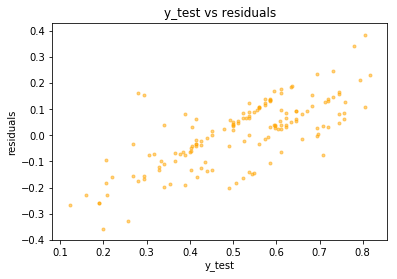

In [212]:
plt.scatter(y_test,y_test-y_pred,c='orange', marker='.', alpha=0.5)
plt.title('y_test vs residuals')
plt.xlabel('y_test')
plt.ylabel('residuals')
plt.savefig('plots/model3_resids.png')
plt.show()

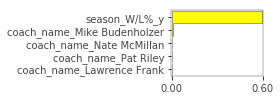

In [200]:
imp =importances(rf_reg, X_test, y_test, X_cols) # permutation
viz = plot_importances(imp[:5],color='yellow')
viz.save('plots/model3_FI.png')
viz.view()

In [199]:
mean_squared_error(y_test,y_pred)

0.01658488453340847

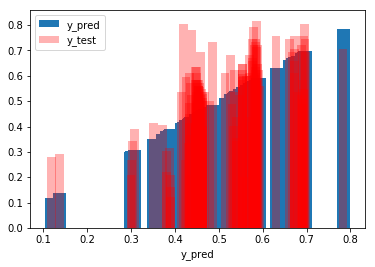

In [232]:
plt.bar(y_pred,width=0.03,height=y_pred,label='y_pred')
plt.bar(y_pred,height=y_test,color='red',width=0.02, alpha=0.3, label='y_test')
plt.legend()
plt.xlabel('y_pred')
plt.savefig('plots/model3_')
plt.show()


In [165]:
mean_squared_error(y_test,X_test['season_W/L%_y'])

0.016847523489932886

In [180]:
X_test.head()['season_W/L%_y']

424    0.183
439    0.293
172    0.671
503    0.537
107    0.402
Name: season_W/L%_y, dtype: float64

In [181]:
imp

,Importance
Feature,
season_W/L%_y,0.766733
coach_name_Earl Watson,0.015558
coach_name_Pat Riley,0.013902
coach_name_Paul Silas,0.006788
coach_name_Mike Budenholzer,0.005063
coach_name_Nate McMillan,0.002926
coach_name_Phil Jackson,0.001131
coach_name_Stan Van Gundy,0.000529
coach_name_Dwane Casey,0.000502
